In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision

import os
import shutil

In [18]:
torchvision.datasets.ImageFolder??

In [2]:
img_dir = r'./dataset2/'

In [3]:
species = ['cloudy', 'rain', 'shine', 'sunrise']

In [4]:
base_dir = r'./4weather'

In [5]:
if not os.path.isdir(base_dir):
    train_dir = os.path.join(base_dir , 'train')
    test_dir = os.path.join(base_dir , 'test')    
    os.mkdir(base_dir)
    os.mkdir(train_dir)
    os.mkdir(test_dir)

    for sta_dir in ['train', 'test']:     
        for spec in species:
            os.mkdir(os.path.join(base_dir, sta_dir, spec))

In [6]:
for i, img_name in enumerate(os.listdir(img_dir)):
    for spec in species:
        if spec in img_name:
            if i%5 == 0:
                s = os.path.join(img_dir, img_name)
                d = os.path.join(base_dir, 'test', spec, img_name)
            else:
                s = os.path.join(img_dir, img_name)
                d = os.path.join(base_dir, 'train', spec, img_name)
            shutil.copyfile(s, d)

In [7]:
for sta_dir in ['train', 'test']:     
    for spec in species:
        print(sta_dir, spec, len(os.listdir(os.path.join(base_dir, sta_dir, spec))))

train cloudy 240
train rain 172
train shine 202
train sunrise 286
test cloudy 60
test rain 43
test shine 51
test sunrise 71


In [8]:
from torchvision import transforms

In [9]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

In [10]:
train_ds =  torchvision.datasets.ImageFolder(
        train_dir,
        transform=transform
    )

In [11]:
test_ds =  torchvision.datasets.ImageFolder(
           test_dir,
           transform=transform
    )

In [12]:
train_ds.classes

['cloudy', 'rain', 'shine', 'sunrise']

In [13]:
train_ds.class_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [16]:
len(train_ds) + len(test_ds)

1125

In [15]:
len(test_ds)

225

In [12]:
BTACH_SIZE = 16

In [13]:
train_dl = torch.utils.data.DataLoader(
                            train_ds,
                            batch_size=BTACH_SIZE,
                            shuffle=True
)

In [14]:
test_dl = torch.utils.data.DataLoader(
                            test_ds,
                            batch_size=BTACH_SIZE,
)

In [17]:
imgs, labels = next(iter(train_dl))

In [18]:
imgs.shape

torch.Size([16, 3, 96, 96])

In [19]:
img = (imgs[0].permute(1,2,0).numpy() + 1)/2

In [20]:
idx_to_class = dict((v, k) for  k, v in train_ds.class_to_idx.items())

In [21]:
idx_to_class

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

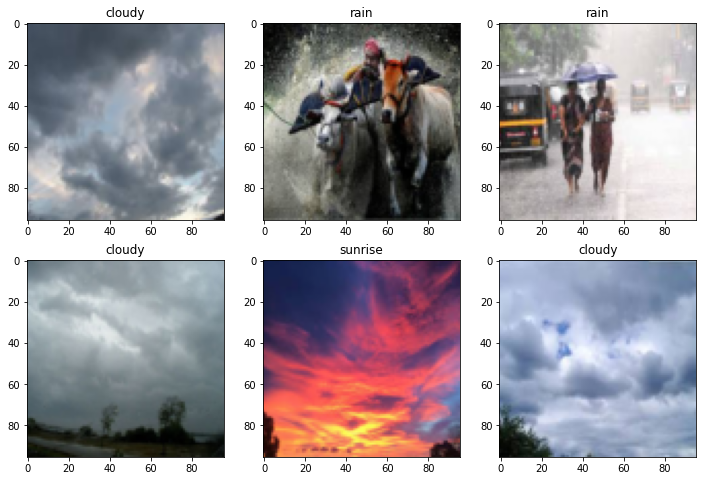

In [22]:
plt.figure(figsize=(12, 8))
for i,(img, label) in enumerate(zip(imgs[:6],labels[:6])):
    img = (img.permute(1,2,0).numpy() + 1)/2
    plt.subplot(2, 3, i+1)
    plt.title(idx_to_class.get(label.item()))
    plt.imshow(img)

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
model = Net()

In [28]:
pred = model(imgs)

In [29]:
pred.shape

torch.Size([16, 4])

In [30]:
if torch.cuda.is_available():
    model.to('cuda')

In [16]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
#此处使用训练代码

In [26]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [27]:
epochs = 30

In [43]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.046 accuracy: 0.69 test_loss：  0.053 test_accuracy: 0.751
epoch:  1 loss：  0.029 accuracy: 0.814 test_loss：  0.037 test_accuracy: 0.818
epoch:  2 loss：  0.027 accuracy: 0.839 test_loss：  0.037 test_accuracy: 0.822
epoch:  3 loss：  0.021 accuracy: 0.878 test_loss：  0.033 test_accuracy: 0.836
epoch:  4 loss：  0.02 accuracy: 0.883 test_loss：  0.04 test_accuracy: 0.862
epoch:  5 loss：  0.017 accuracy: 0.897 test_loss：  0.033 test_accuracy: 0.889
epoch:  6 loss：  0.013 accuracy: 0.919 test_loss：  0.037 test_accuracy: 0.871
epoch:  7 loss：  0.009 accuracy: 0.941 test_loss：  0.035 test_accuracy: 0.876
epoch:  8 loss：  0.012 accuracy: 0.922 test_loss：  0.036 test_accuracy: 0.893
epoch:  9 loss：  0.008 accuracy: 0.954 test_loss：  0.047 test_accuracy: 0.876
epoch:  10 loss：  0.006 accuracy: 0.964 test_loss：  0.05 test_accuracy: 0.88
epoch:  11 loss：  0.004 accuracy: 0.981 test_loss：  0.052 test_accuracy: 0.893
epoch:  12 loss：  0.006 accuracy: 0.966 test_loss：  0.038 test_accu

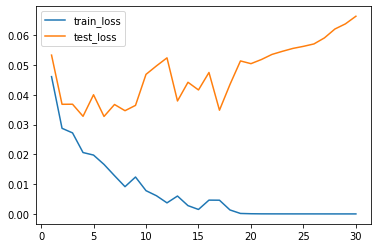

In [44]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

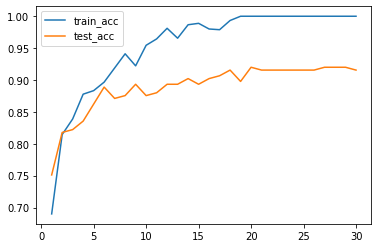

In [45]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

# 添加dropout层

In [72]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.drop = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

In [73]:
model = Net()
if torch.cuda.is_available():
    model.to('cuda')

In [74]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
epochs = 30

In [76]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.05 accuracy: 0.654 test_loss：  0.042 test_accuracy: 0.733
epoch:  1 loss：  0.032 accuracy: 0.768 test_loss：  0.036 test_accuracy: 0.791
epoch:  2 loss：  0.029 accuracy: 0.811 test_loss：  0.04 test_accuracy: 0.747
epoch:  3 loss：  0.026 accuracy: 0.83 test_loss：  0.033 test_accuracy: 0.84
epoch:  4 loss：  0.02 accuracy: 0.89 test_loss：  0.034 test_accuracy: 0.871
epoch:  5 loss：  0.017 accuracy: 0.881 test_loss：  0.041 test_accuracy: 0.84
epoch:  6 loss：  0.017 accuracy: 0.901 test_loss：  0.036 test_accuracy: 0.84
epoch:  7 loss：  0.014 accuracy: 0.929 test_loss：  0.032 test_accuracy: 0.871
epoch:  8 loss：  0.009 accuracy: 0.943 test_loss：  0.047 test_accuracy: 0.889
epoch:  9 loss：  0.007 accuracy: 0.958 test_loss：  0.049 test_accuracy: 0.88
epoch:  10 loss：  0.007 accuracy: 0.967 test_loss：  0.037 test_accuracy: 0.893
epoch:  11 loss：  0.004 accuracy: 0.978 test_loss：  0.045 test_accuracy: 0.898
epoch:  12 loss：  0.002 accuracy: 0.987 test_loss：  0.039 test_accuracy

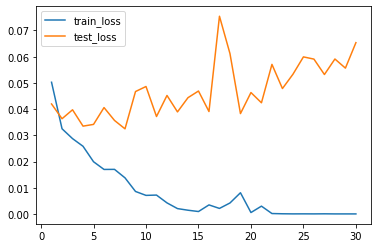

In [77]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

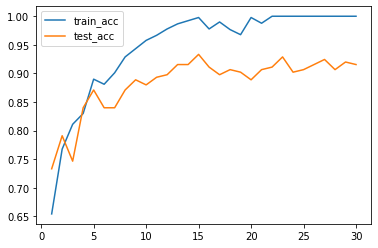

In [78]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

# 预训练模型

### 使用VGG模型

In [49]:
model = torchvision.models.vgg16(pretrained=True)

In [50]:
model.training

True

In [51]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [52]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [87]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [53]:
for param in model.features.parameters(): 
    param.requires_grad = False

In [89]:
model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [30]:
model.classifier[-1].out_features = 4

In [31]:
if torch.cuda.is_available():
    model.to('cuda')
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [92]:
# 此处训练代码
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.119 accuracy: 0.79 test_loss：  0.067 test_accuracy: 0.898
epoch:  1 loss：  0.048 accuracy: 0.929 test_loss：  0.041 test_accuracy: 0.933
epoch:  2 loss：  0.032 accuracy: 0.944 test_loss：  0.069 test_accuracy: 0.916
epoch:  3 loss：  0.063 accuracy: 0.948 test_loss：  0.099 test_accuracy: 0.92
epoch:  4 loss：  0.092 accuracy: 0.948 test_loss：  0.527 test_accuracy: 0.822
epoch:  5 loss：  0.077 accuracy: 0.957 test_loss：  0.263 test_accuracy: 0.92
epoch:  6 loss：  0.126 accuracy: 0.956 test_loss：  0.487 test_accuracy: 0.911
epoch:  7 loss：  0.18 accuracy: 0.954 test_loss：  0.411 test_accuracy: 0.933
epoch:  8 loss：  0.149 accuracy: 0.959 test_loss：  0.853 test_accuracy: 0.911
epoch:  9 loss：  0.153 accuracy: 0.971 test_loss：  0.85 test_accuracy: 0.947
epoch:  10 loss：  0.148 accuracy: 0.976 test_loss：  1.014 test_accuracy: 0.933
epoch:  11 loss：  0.107 accuracy: 0.986 test_loss：  1.079 test_accuracy: 0.907
epoch:  12 loss：  0.117 accuracy: 0.98 test_loss：  0.563 test_accur

进一步修改dropout值

In [93]:
model.classifier.children()

<generator object Module.children at 0x0000021FFD164548>

In [94]:
list(model.classifier.children())

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4, bias=True)]

In [32]:
for layer in model.classifier.children(): 
    if(type(layer) == nn.Dropout): 
        layer.p = 0.2

In [33]:
if torch.cuda.is_available():
    model.to('cuda')
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [99]:
# 此处训练代码
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(10):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.04 accuracy: 0.997 test_loss：  1.76 test_accuracy: 0.96
epoch:  1 loss：  0.0 accuracy: 1.0 test_loss：  1.709 test_accuracy: 0.951
epoch:  2 loss：  0.0 accuracy: 1.0 test_loss：  1.857 test_accuracy: 0.951
epoch:  3 loss：  0.0 accuracy: 1.0 test_loss：  1.866 test_accuracy: 0.96
epoch:  4 loss：  0.0 accuracy: 1.0 test_loss：  1.803 test_accuracy: 0.951
epoch:  5 loss：  0.137 accuracy: 0.99 test_loss：  3.658 test_accuracy: 0.933
epoch:  6 loss：  0.012 accuracy: 0.998 test_loss：  1.955 test_accuracy: 0.96
epoch:  7 loss：  0.123 accuracy: 0.993 test_loss：  3.929 test_accuracy: 0.924
epoch:  8 loss：  0.371 accuracy: 0.983 test_loss：  2.747 test_accuracy: 0.938
epoch:  9 loss：  0.0 accuracy: 1.0 test_loss：  2.032 test_accuracy: 0.969


使用数据增强

In [36]:
train_transform =transforms.Compose([transforms.RandomResizedCrop((96,96)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
                                      ])

In [37]:
test_transform =transforms.Compose([transforms.Resize((96,96)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
                                      ])

In [117]:
# 创建数据集，并训练

In [38]:
train_ds =  torchvision.datasets.ImageFolder(
        train_dir,
        transform=train_transform
    )

test_ds =  torchvision.datasets.ImageFolder(
        test_dir,
        transform=test_transform
    )

In [39]:
train_dl = torch.utils.data.DataLoader(
                            train_ds,
                            batch_size=BTACH_SIZE,
                            shuffle=True
)

test_dl = torch.utils.data.DataLoader(
                            test_ds,
                            batch_size=BTACH_SIZE,
)

In [40]:
if torch.cuda.is_available():
    model.to('cuda')
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
# 此处训练代码
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(30):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.083 accuracy: 0.774 test_loss：  0.024 test_accuracy: 0.938
epoch:  1 loss：  0.029 accuracy: 0.911 test_loss：  0.023 test_accuracy: 0.92
epoch:  2 loss：  0.03 accuracy: 0.914 test_loss：  0.025 test_accuracy: 0.92
epoch:  3 loss：  0.032 accuracy: 0.92 test_loss：  0.064 test_accuracy: 0.907
epoch:  4 loss：  0.036 accuracy: 0.922 test_loss：  0.038 test_accuracy: 0.889
epoch:  5 loss：  0.022 accuracy: 0.923 test_loss：  0.049 test_accuracy: 0.893
epoch:  6 loss：  0.024 accuracy: 0.931 test_loss：  0.028 test_accuracy: 0.902
epoch:  7 loss：  0.018 accuracy: 0.929 test_loss：  0.02 test_accuracy: 0.938
epoch:  8 loss：  0.024 accuracy: 0.937 test_loss：  0.031 test_accuracy: 0.898
epoch:  9 loss：  0.016 accuracy: 0.944 test_loss：  0.025 test_accuracy: 0.938
epoch:  10 loss：  0.018 accuracy: 0.939 test_loss：  0.056 test_accuracy: 0.92
epoch:  11 loss：  0.038 accuracy: 0.914 test_loss：  0.039 test_accuracy: 0.951
epoch:  12 loss：  0.041 accuracy: 0.926 test_loss：  0.083 test_accur

# 使用resnet18

In [39]:
model = torchvision.models.resnet18(pretrained=True)

In [40]:
if torch.cuda.is_available():
    model.to('cuda')

In [41]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [42]:
for param in model.parameters():
    param.requires_grad = False

In [43]:
num_ftrs = model.fc.in_features

In [44]:
model.fc = nn.Linear(num_ftrs, 4).cuda()

In [45]:
# 设置学习速率衰减

In [46]:
# Decay LR by a factor of 0.1 every 7 epochs
from torch.optim import lr_scheduler
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [47]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [48]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(30):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.095 accuracy: 0.266 test_loss：  0.098 test_accuracy: 0.213
epoch:  1 loss：  0.082 accuracy: 0.407 test_loss：  0.097 test_accuracy: 0.24
epoch:  2 loss：  0.071 accuracy: 0.54 test_loss：  0.096 test_accuracy: 0.249
epoch:  3 loss：  0.065 accuracy: 0.62 test_loss：  0.096 test_accuracy: 0.28
epoch:  4 loss：  0.058 accuracy: 0.67 test_loss：  0.096 test_accuracy: 0.28
epoch:  5 loss：  0.054 accuracy: 0.727 test_loss：  0.097 test_accuracy: 0.289
epoch:  6 loss：  0.05 accuracy: 0.762 test_loss：  0.097 test_accuracy: 0.302
epoch:  7 loss：  0.045 accuracy: 0.814 test_loss：  0.097 test_accuracy: 0.293
epoch:  8 loss：  0.047 accuracy: 0.781 test_loss：  0.097 test_accuracy: 0.289
epoch:  9 loss：  0.046 accuracy: 0.79 test_loss：  0.097 test_accuracy: 0.293
epoch:  10 loss：  0.046 accuracy: 0.8 test_loss：  0.097 test_accuracy: 0.298
epoch:  11 loss：  0.046 accuracy: 0.8 test_loss：  0.097 test_accuracy: 0.302
epoch:  12 loss：  0.046 accuracy: 0.81 test_loss：  0.097 test_accuracy: 0.